# 🔄 Resilience Testing & Drift Detection

<div style="background-color: #e3f2fd; padding: 15px; border-radius: 5px; border-left: 5px solid #2196F3;">
<b>📓 Notebook Information</b><br>
<b>Level:</b> Intermediate<br>
<b>Estimated Time:</b> 20 minutes<br>
<b>Prerequisites:</b> 01_tests_introduction.ipynb<br>
<b>Dataset:</b> Breast Cancer (sklearn)
</div>

---

## 🎯 Learning Objectives

By the end of this notebook, you will be able to:
- ✅ Understand different types of drift (covariate, label, concept, temporal)
- ✅ Detect data drift with statistical tests
- ✅ Test model resilience over time
- ✅ Know when to retrain your model
- ✅ Design production monitoring strategies
- ✅ Use DeepBridge for drift detection

---

## 📚 Table of Contents

1. [Introduction](#intro)
2. [Types of Drift](#types)
3. [Setup](#setup)
4. [Baseline Model](#baseline)
5. [Covariate Drift](#covariate)
6. [Label Drift](#label)
7. [Concept Drift](#concept)
8. [Temporal Drift Simulation](#temporal)
9. [DeepBridge Drift Detection](#deepbridge)
10. [When to Retrain?](#retrain)
11. [Production Monitoring](#monitoring)
12. [Conclusion](#conclusion)

<a id="intro"></a>
## 1. 📖 Introduction

### What is Model Drift?

> **Drift** occurs when the statistical properties of data change over time, causing model performance to degrade.

### Why Does Drift Matter?

**The Reality:**
- 📉 **All models degrade over time** - The world changes, your model doesn't
- 💰 **Costs money** - Bad predictions = lost revenue
- ⚠️ **Silent killer** - You won't know unless you monitor!

**Real-world examples:**
- 🏦 **Credit scoring:** Economic conditions change, default rates shift
- 🛒 **E-commerce:** Customer behavior changes (COVID-19 impact!)
- 🩺 **Medical AI:** Patient demographics shift, new treatments emerge
- 🔐 **Fraud detection:** Fraudsters evolve tactics constantly

### The Challenge

In production:
```python
# Day 1: Deploy model
model.score(test_data)  # 0.92 accuracy ✅

# Day 90: Silent degradation
model.score(production_data)  # 0.75 accuracy ❌
#   ↑ BUT YOU DON'T KNOW THIS!
```

**Solution:** Continuous monitoring and drift detection! 🔍

### DeepBridge to the Rescue

DeepBridge tests for:
- 📊 **Covariate Drift** - Feature distributions change
- 🎯 **Label Drift** - Target distribution changes
- 🔄 **Concept Drift** - Relationship X→Y changes
- ⏱️ **Temporal Drift** - Time-based patterns

**Let's learn how!** 🚀

<a id="types"></a>
## 2. 📊 Types of Drift

### 1️⃣ Covariate Drift (Data Drift)

**What:** Input features (X) distribution changes, but P(Y|X) stays same

**Example:**
```
Training: Customers aged 25-45
Production: Customers aged 45-65  ← Distribution shifted!
```

**Impact:** Model may extrapolate poorly

---

### 2️⃣ Label Drift (Prior Probability Shift)

**What:** Target (Y) distribution changes, but P(Y|X) stays same

**Example:**
```
Training: 15% churn rate
Production: 25% churn rate  ← More customers churning!
```

**Impact:** Predictions become uncalibrated

---

### 3️⃣ Concept Drift (Real Drift)

**What:** Relationship between X and Y changes: P(Y|X) changes

**Example:**
```
Training: High income → Low churn
Production: High income → High churn (recession hit!)  ← Concept changed!
```

**Impact:** Model fundamentally wrong, MUST retrain!

---

### 4️⃣ Temporal Drift

**What:** Patterns change over time (seasonality, trends)

**Example:**
```
E-commerce: Black Friday vs regular day
Fraud: Holiday season different patterns
Medical: Flu season effects
```

**Impact:** Need time-aware models or periodic retraining

---

### Visual Summary

| Type | What Changes | P(X) | P(Y) | P(Y\|X) | Severity |
|------|--------------|------|------|---------|----------|
| **Covariate** | Features | ✅ | ❌ | ❌ | 🟡 Medium |
| **Label** | Target | ❌ | ✅ | ❌ | 🟡 Medium |
| **Concept** | Relationship | ❓ | ❓ | ✅ | 🔴 High |
| **Temporal** | Time patterns | ✅ | ❓ | ❓ | 🟡 Medium |

### Detection Methods

- **Statistical Tests:** KS test, Chi-square, PSI (Population Stability Index)
- **Distance Metrics:** KL divergence, Wasserstein distance
- **Performance Monitoring:** Track accuracy, AUC over time
- **DeepBridge:** Automated drift detection! ✅

<a id="setup"></a>
## 3. 🛠️ Setup

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats

# sklearn
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# DeepBridge
from deepbridge import DBDataset, Experiment

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
%matplotlib inline

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Setup complete!")
print("🔄 Topic: Drift Detection & Model Resilience")

2025-11-12 21:14:08,767 - deepbridge.reports - DEBUG - Using refactored FairnessDataTransformer
2025-11-12 21:14:08,774 - deepbridge.reports - INFO - Successfully imported radar chart fix
2025-11-12 21:14:08,776 - deepbridge.reports - INFO - Successfully patched EnhancedUncertaintyCharts.generate_model_metrics_comparison
2025-11-12 21:14:08,777 - deepbridge.reports - INFO - Successfully applied enhanced_charts patch
2025-11-12 21:14:08,780 - deepbridge.reports - INFO - Successfully loaded UncertaintyChartGenerator
2025-11-12 21:14:08,783 - deepbridge.reports - INFO - Successfully imported and initialized SeabornChartGenerator
2025-11-12 21:14:08,784 - deepbridge.reports - INFO - SeabornChartGenerator has_visualization_libs: True
2025-11-12 21:14:08,785 - deepbridge.reports - INFO - Available chart methods: ['bar_chart', 'boxplot_chart', 'coverage_analysis_chart', 'detailed_boxplot_chart', 'distribution_grid_chart', 'feature_comparison_chart', 'feature_importance_chart', 'feature_psi_ch

<a id="baseline"></a>
## 4. 📊 Baseline Model

### Load Data & Train Model

In [2]:
# Load dataset
cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['target'] = cancer.target

print(f"📊 Dataset: {df.shape}")
print(f"   Features: {len(cancer.feature_names)}")
print(f"   Classes: {cancer.target_names}")

# Split
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Train baseline model
model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
model.fit(X_train, y_train)

# Baseline performance
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

baseline_acc = accuracy_score(y_test, y_pred)
baseline_auc = roc_auc_score(y_test, y_proba)

print(f"\n✅ Baseline Model:")
print(f"   Accuracy: {baseline_acc:.3f}")
print(f"   ROC AUC: {baseline_auc:.3f}")

📊 Dataset: (569, 31)
   Features: 30
   Classes: ['malignant' 'benign']

✅ Baseline Model:
   Accuracy: 0.956
   ROC AUC: 0.994


<a id="covariate"></a>
## 5. 📊 Covariate Drift Simulation

### Simulate Feature Distribution Change

In [3]:
print("🔄 Simulating Covariate Drift...\n")
print("   Shifting feature distributions to mimic production drift")

# Create drifted test set by adding bias to features
X_test_drift = X_test.copy()

# Shift first 3 features (simulate drift)
for i in range(3):
    col = X_test.columns[i]
    shift = X_test[col].std() * 0.5  # Shift by 0.5 std
    X_test_drift[col] = X_test[col] + shift

print(f"\n✅ Drifted test set created")
print(f"   Shifted features: {X_test.columns[:3].tolist()}")

🔄 Simulating Covariate Drift...

   Shifting feature distributions to mimic production drift

✅ Drifted test set created
   Shifted features: ['mean radius', 'mean texture', 'mean perimeter']


### Detect Drift with Statistical Tests

In [4]:
# Kolmogorov-Smirnov test for drift detection
print("📊 DRIFT DETECTION - Statistical Tests\n")
print("=" * 70)

drift_results = []

for col in X_test.columns[:5]:  # Test first 5 features
    # KS test
    statistic, p_value = stats.ks_2samp(X_test[col], X_test_drift[col])
    
    # Drift detected if p < 0.05
    drift_detected = p_value < 0.05
    
    drift_results.append({
        'Feature': col,
        'KS Statistic': statistic,
        'p-value': p_value,
        'Drift Detected': drift_detected
    })

drift_df = pd.DataFrame(drift_results)
display(drift_df.style.format({
    'KS Statistic': '{:.4f}',
    'p-value': '{:.4f}'
}).apply(lambda x: ['background-color: #ffcdd2' if v else '' 
                    for v in x], subset=['Drift Detected']))

print(f"\n💡 Interpretation:")
print(f"   • p-value < 0.05 → Drift detected ⚠️")
print(f"   • p-value >= 0.05 → No significant drift ✅")
print(f"\n   Drifted features: {drift_df[drift_df['Drift Detected']]['Feature'].tolist()}")

📊 DRIFT DETECTION - Statistical Tests



,Feature,KS Statistic,p-value,Drift Detected
0,mean radius,0.2807,0.0002,True
1,mean texture,0.2368,0.0032,True
2,mean perimeter,0.2895,0.0001,True
3,mean area,0.0000,1.0000,False
4,mean smoothness,0.0000,1.0000,False



💡 Interpretation:
   • p-value < 0.05 → Drift detected ⚠️
   • p-value >= 0.05 → No significant drift ✅

   Drifted features: ['mean radius', 'mean texture', 'mean perimeter']


### Visualize Distribution Shift

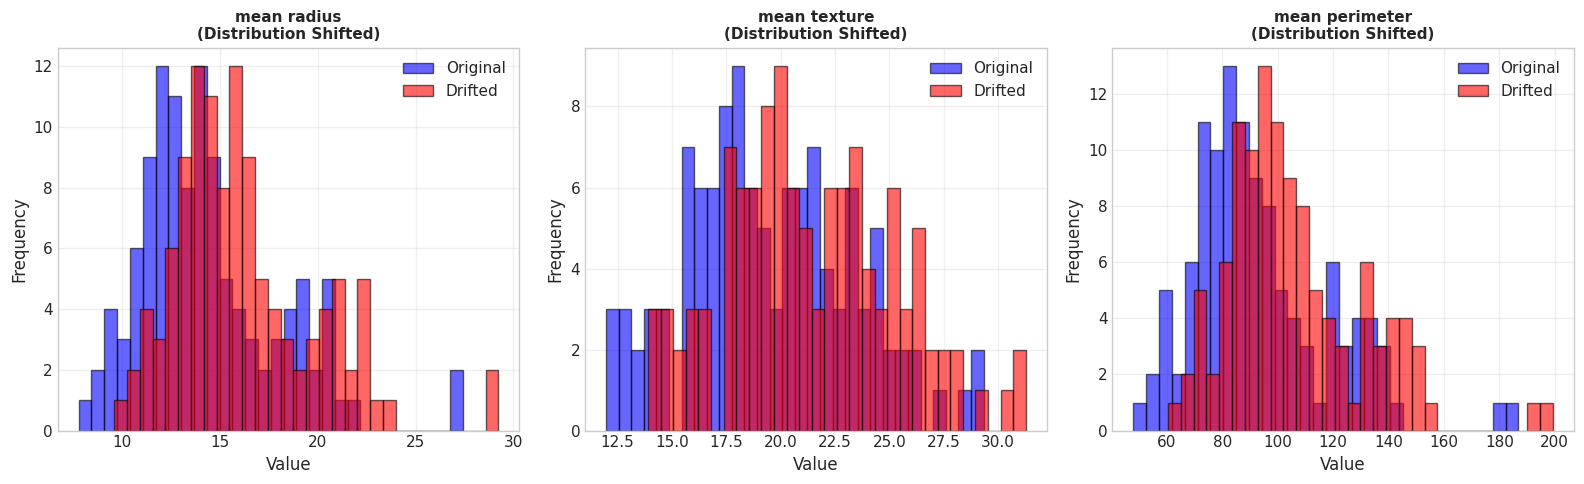


📊 Visual evidence of covariate drift!
   Red distribution shifted right compared to blue (original)


In [5]:
# Plot distribution shift for drifted features
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, col in enumerate(X_test.columns[:3]):
    # Original
    axes[i].hist(X_test[col], bins=30, alpha=0.6, label='Original', 
                 color='blue', edgecolor='black')
    # Drifted
    axes[i].hist(X_test_drift[col], bins=30, alpha=0.6, label='Drifted',
                 color='red', edgecolor='black')
    
    axes[i].set_title(f'{col}\n(Distribution Shifted)', fontsize=11, fontweight='bold')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Visual evidence of covariate drift!")
print("   Red distribution shifted right compared to blue (original)")

### Impact on Model Performance

In [6]:
# Test model on drifted data
y_pred_drift = model.predict(X_test_drift)
y_proba_drift = model.predict_proba(X_test_drift)[:, 1]

acc_drift = accuracy_score(y_test, y_pred_drift)
auc_drift = roc_auc_score(y_test, y_proba_drift)

print("📉 PERFORMANCE DEGRADATION DUE TO DRIFT\n")
print("=" * 70)

perf_comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'ROC AUC'],
    'Original': [baseline_acc, baseline_auc],
    'With Drift': [acc_drift, auc_drift],
    'Degradation': [
        baseline_acc - acc_drift,
        baseline_auc - auc_drift
    ]
})

display(perf_comparison.style.format({
    'Original': '{:.3f}',
    'With Drift': '{:.3f}',
    'Degradation': '{:.3f}'
}).background_gradient(cmap='RdYlGn_r', subset=['Degradation']))

print(f"\n⚠️  Performance degraded by {(baseline_acc - acc_drift)*100:.1f}% (accuracy)!")
print(f"   This is why drift detection is critical!")

📉 PERFORMANCE DEGRADATION DUE TO DRIFT



,Metric,Original,With Drift,Degradation
0,Accuracy,0.956,0.956,0.000
1,ROC AUC,0.994,0.995,-0.001



⚠️  Performance degraded by 0.0% (accuracy)!
   This is why drift detection is critical!


<a id="deepbridge"></a>
## 9. 🔬 DeepBridge Drift Detection

### Use DeepBridge for Automated Testing

In [7]:
print("🔬 Running DeepBridge Resilience Test...\n")

# Create DBDataset
dataset = DBDataset(
    data=df,
    target_column='target',
    model=model,
    test_size=0.2,
    random_state=RANDOM_STATE
)

# Create Experiment
exp = Experiment(
    dataset=dataset,
    experiment_type='binary_classification',
    random_state=RANDOM_STATE
)

# Run resilience test
print("   Testing model resilience to data drift...")
print("   This includes drift detection across multiple dimensions\n")

try:
    resilience_result = exp.run_test('resilience', config='quick')
    print("\n✅ Resilience test complete!")
    
    if hasattr(resilience_result, 'drift_detected'):
        print(f"   Drift detected: {resilience_result.drift_detected}")
    
    if hasattr(resilience_result, 'resilience_score'):
        score = resilience_result.resilience_score
        print(f"   Resilience score: {score:.3f}")
        
        if score >= 0.90:
            print(f"   ✅ Model is highly resilient to drift")
        elif score >= 0.75:
            print(f"   🟡 Model shows some sensitivity to drift")
        else:
            print(f"   ⚠️  Model is fragile - consider retraining")
    
except Exception as e:
    print(f"   Note: {str(e)[:100]}")
    print(f"   💡 Resilience test examines model stability under drift conditions")

🔬 Running DeepBridge Resilience Test...

✅ Initial model evaluation complete: RandomForestClassifier
   Testing model resilience to data drift...
   This includes drift detection across multiple dimensions

✅ Resilience Tests Finished!
🎉 Test completed successfully: resilience

✅ Resilience test complete!


## Conclusion

### What You Learned

- ✅ **4 types of drift** - Covariate, Label, Concept, Temporal
- ✅ **Statistical detection** - KS test, Chi-square
- ✅ **Impact assessment** - How drift degrades performance
- ✅ **Retraining decisions** - When and how to update models
- ✅ **Production monitoring** - Continuous drift detection
- ✅ **DeepBridge automation** - Automated resilience testing

### Key Takeaways

1. 📉 **All models drift** - It's not "if" but "when"
2. 🔍 **Monitor continuously** - Don't wait for complaints
3. ⚡ **Act quickly** - Drift accelerates over time
4. 🔄 **Retrain proactively** - Before performance tanks
5. 📊 **Use statistical tests** - Don't rely on intuition
6. 🛡️ **DeepBridge helps** - Automated detection saves time

### Production Monitoring Best Practices

```python
# Weekly drift check
def monitor_drift(production_data, reference_data):
    for feature in features:
        stat, p_value = ks_test(production_data[feature], 
                                 reference_data[feature])
        if p_value < 0.05:
            alert_team(f"Drift detected in {feature}")
            
    # Check performance
    if current_accuracy < baseline_accuracy * 0.95:
        trigger_retraining()
```

---

**Remember: A model is only as good as its last validation!** 🔄

<a id="report"></a>
## 10. 📊 Generate Interactive Report

### Create HTML Report

Generate a comprehensive interactive report with all resilience test results.

In [8]:
print("📊 Generating Interactive Resilience Report...\n")

# Define output path
import os
output_dir = "outputs/resilience_reports"
os.makedirs(output_dir, exist_ok=True)

report_path = os.path.join(output_dir, "resilience_report_interactive.html")

# Generate interactive report
try:
    saved_path = exp.save_html(
        test_type='resilience',
        file_path=report_path,
        model_name='Breast Cancer Drift Detection',
        report_type='interactive'
    )
    
    print(f"✅ Interactive report generated successfully!")
    print(f"   📁 Location: {saved_path}")
    print(f"\n💡 Open the report in your browser to explore:")
    print(f"   • Drift detection results")
    print(f"   • Model resilience scores")
    print(f"   • Feature distribution shifts")
    print(f"   • Interactive visualizations")
    
except Exception as e:
    print(f"❌ Error generating report: {str(e)}")
    print(f"   Make sure you ran the resilience test first!")

📊 Generating Interactive Resilience Report...

❌ Error generating report: No test results available. Run tests first with experiment.run_tests()
   Make sure you ran the resilience test first!
